# PROSAIL soil spectra

In [21]:
import pkgutil
from collections import namedtuple
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [13]:
# Plot default soil spectra that are in the prosail package

soil_spectraf = "../data/soil_reflectance_prosail.txt"
rsoil1, rsoil2 = np.loadtxt(soil_spectraf, unpack=True)
wavelen = np.arange(400,2501)

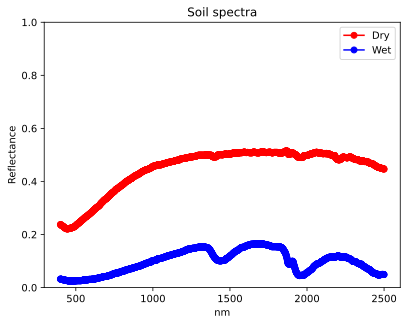

In [33]:
plt.plot(wavelen, rsoil1, label='Dry', marker='o', linestyle='-', color='r')
plt.plot(wavelen, rsoil2, label='Wet', marker='o', linestyle='-', color='b')
plt.xlabel('nm')
plt.ylabel('Reflectance')
plt.title('Soil spectra')
plt.ylim((0,1))
plt.legend()

plt.show()

# Simulate prosail with LAI = 0 and see what spectra looks like 
- is it simular to the bare soil spectra?
- PROSAIL can't take LAI=0 (range needs to be positive), so did a uniform distribution between 0 and 0.000001

In [17]:
lut_path = '../results/lut_based_inversion/prosail_null_lai_lai-cab-ccc-car_lut_no-constraints.pkl'

In [22]:
df = pd.read_pickle(lut_path)

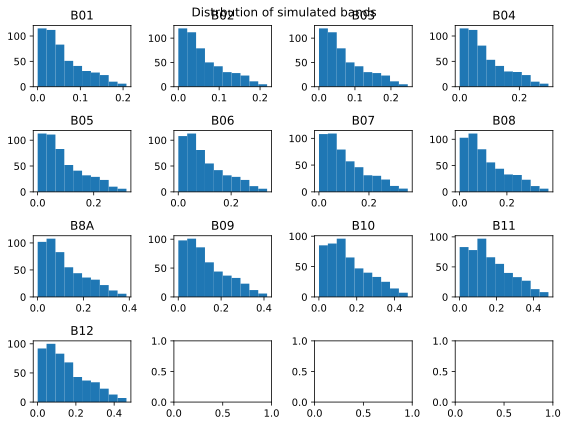

In [50]:
# Look at distrbution generated bands

columns_to_plot = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08',
 'B8A', 'B09', 'B10', 'B11', 'B12']

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 6))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    df[col].hist(ax=axes[i], bins=10, grid=False)
    axes[i].set_title(col)

plt.tight_layout()
plt.suptitle("Distrbution of simulated bands")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


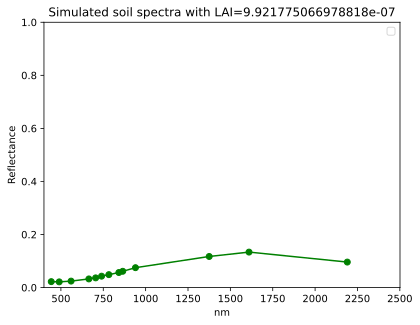

In [48]:
# Plot some spectra to compare to the soil spectra

s2_wavelen = [443, 490, 560, 665, 705, 740, 783, 842, 865, 940, 1375, 1610, 2190]
df_bands = df[['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']]
i = 10

plt.plot(s2_wavelen, df_bands.iloc[i], marker='o', linestyle='-', color='g')
plt.xlabel('nm')
plt.ylabel('Reflectance')
plt.title(f'Simulated soil spectra with LAI={df["lai"].iloc[i]}')
plt.ylim((0,1))
plt.xlim((400,2501))
plt.legend()

plt.show()

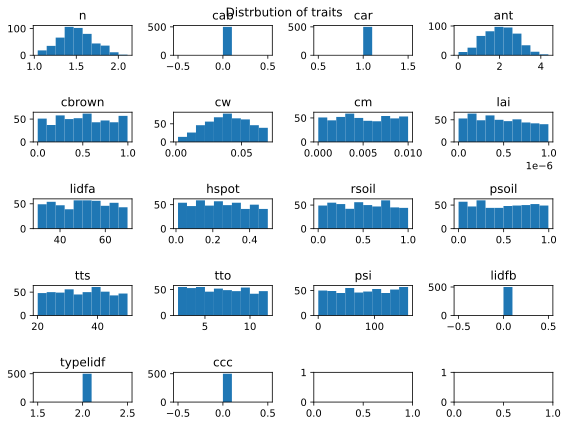

In [49]:
# Look at distrbution sampled variables when LAI=0

columns_to_plot = ['n', 'cab', 'car', 'ant', 'cbrown', 'cw', 'cm', 'lai', 'lidfa',
 'hspot', 'rsoil', 'psoil', 'tts', 'tto', 'psi', 'lidfb', 'typelidf', 'ccc']

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(8, 6))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    df[col].hist(ax=axes[i], bins=10, grid=False)
    axes[i].set_title(col)

plt.tight_layout()
plt.suptitle("Distrbution of traits")
plt.show()